In [ ]:
!pip install matplotlib #==3.3.0
!pip install nibabel #==3.2
!pip install nilearn
!pip install simpleitk
!pip install SimpleITK-SimpleElastix 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.7 MB/s eta 0:00:00


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import cv2
import pandas as pd
import scipy.ndimage as ndi
import seaborn as sns
import SimpleITK as sitk
import sys
import os
import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/Final-Year-Project')
#!ls

In [ ]:
import os

def load_folder_nibabel(dir_name): 
  directory = dir_name
  scans = [] #stores all scans of a certain segmentation tool and point in time in an iterable list for later processing
  
  # iterate over each files in the directory
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      patient_id = filename[:10] #each scan is stored so that the patient id comes first

      # checking if it is a file
      if os.path.isfile(f):      
          scan = nib.load(f)
          scan.header['db_name'] = patient_id #in order to make sure that the scans are clearly identifiable later -> for those scan that don't have it already (like MONAI and FS) the db_name is that of the patient id which can be indexed later to compare scans of the same patient
          scans.append(scan)
          

  return scans

In [ ]:
# using the function to load in the pre-processed segementation data using nibabel:

FS_original_scans = load_folder_nibabel('FS_Segmentations')
MONAI_original_scans = load_folder_nibabel('MONAI_Segmentations') 
SNT_original_scans = load_folder_nibabel('SNT_Segmentations') 
MAPER_original_scans = load_folder_nibabel('MAPER_Segmentations') 

FS_original_extra_scans = load_folder_nibabel('FS_Extra_Original')
MAPER_original_extra_scans = load_folder_nibabel('MAPER_Extra_Original')
SNT_original_extra_scans = load_folder_nibabel('SNT_Extra_Original')

In [ ]:
# in order to get the patient ids corresponding to each scan use the header information -> to create dataframe 
def get_patient_ids(scans):
  patient_ids = []

  for i in range(len(scans)):
    id = str(scans[i].header["db_name"])
    patient_ids.append(id[2:-1]) #the id is stored between b' ' which is not needed


  return patient_ids   

In [ ]:
# create a dict which holds a patient's id with the corresponding scan of a tool so that it can be ordered easily later
def dict_patient_id_scan(list_scans_tool):
  patient_ids = get_patient_ids(list_scans_tool)
  dict_patient_id_scan = {}

  for i in range(len(list_scans_tool)):
    dict_patient_id_scan[patient_ids[i]] = list_scans_tool[i]

  return dict_patient_id_scan

In [ ]:
#importing a spreadsheet holding the associated disease stage diagnosis CN, MCI and AD for each patient id so that it can be used easily 
diagnosis_ids = pd.read_csv('id_and_diagnosis.csv', sep=',')
diagnosis_ids = diagnosis_ids.T
diagnosis_ids.columns = diagnosis_ids.iloc[0]
diagnosis_ids = diagnosis_ids.iloc[1:]
diagnosis_ids.head()

Patient_ID,002_S_0685,003_S_0981,003_S_0907,005_S_0610,007_S_1222,035_S_0156,035_S_0048,073_S_0089,002_S_0413,002_S_0295,...,130_S_1290,057_S_0474,027_S_1081,024_S_1171,020_S_0213,013_S_1205,005_S_0814,002_S_0619,002_S_1018,002_S_0938
Diagnosis,CN,CN,CN,CN,CN,CN,CN,CN,CN,CN,...,AD,AD,AD,AD,AD,AD,AD,AD,AD,AD
Sex,F,F,F,M,F,M,M,M,F,M,...,F,F,M,M,M,M,F,M,F,F


In [ ]:
# Creating Binary Hippocampal Volume Masks:

def binary_segmentation_mask(scan, seg_nums, tool= 'other', scan_unpacked = True, reorient=False):

  if reorient == True:
    scan = nib.as_closest_canonical(scan)


  if scan_unpacked == False: #depending on whether a pre-processed array or the nifti file is input directly the scan data needs to be unpacked (different function uses)
    scan = scan.get_fdata()

  # each of these numbers belongs to the left or right hippocampus
  #accounting for the outlier cases of the semi-manual scan segmentation (SNT) which for some scans use different segment number for the hippocampi -> thus finding these indiviudally for each scan
  if tool == 'SNT':
    pix_nums = np.unique(scan) #the intensity at index 0 will always be 0 which corresponds to the black background 
    seg_num1 = pix_nums[1]
    seg_num2 = pix_nums[2]

  else:
    seg_num1 = seg_nums[0]
    seg_num2 = seg_nums[1]
  
  #Creating binary mask from voxels that are of either hippocampal label
  seg1_binary_mask = scan == seg_num1
  seg2_binary_mask = scan == seg_num2

  #combining the left and right hippocampus bianry masks:
  binary_mask = seg1_binary_mask + seg2_binary_mask
  binary_mask = np.reshape(binary_mask, (binary_mask.shape[0], binary_mask.shape[1], binary_mask.shape[2])) #the thresholding adds an extra (,,,1) at the end of the 3D image array which is not needed
  binary_mask = binary_mask.astype(int) #converting False - 0 and True to 1
  
  return binary_mask

In [ ]:
def list_binary_segmentation_mask(scan_list, seg_nums, tool= 'other', scan_unpacked = True, reorient=False):

  binary_mask_list = []

  for scan in range(len(scan_list)):
    binary_mask = binary_segmentation_mask(scan_list[scan], seg_nums, tool, scan_unpacked, reorient)
    binary_mask_list.append(binary_mask)

  return binary_mask_list

In [ ]:
# the code is adapted from this SITK tutorial: https://github.com/SimpleITK/TUTORIAL/blob/main/05_basic_registration.ipynb

def register_masks(fixed_binary_mask, moving_binary_mask):

  #loading the binary masks of two segmentations as SITK images:
  fixed_image = sitk.Cast(sitk.GetImageFromArray(fixed_binary_mask), sitk.sitkFloat32)
  moving_image = sitk.Cast(sitk.GetImageFromArray(moving_binary_mask), sitk.sitkFloat32)

  #fitting an intial transform which centers the images as a start
  initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Similarity3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

  #define the registration method's parameters:
  registration_method = sitk.ImageRegistrationMethod()
  registration_method.SetMetricAsMeanSquares()
  registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
  registration_method.SetMetricSamplingPercentage(0.1)
  registration_method.SetInterpolator(sitk.sitkLinear)

  #Defining the Optimizer Parameters for the final rigid translation:
  registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
  registration_method.SetOptimizerScalesFromPhysicalShift()
  registration_method.SetInitialTransform(initial_transform, inPlace=True)

  #Executing the final registration after training:
  final_transform = registration_method.Execute(fixed_image, moving_image)
  moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

  #casting the SITK image back to an np.array to be plotted/compared:
  moving_resampled_arr = sitk.GetArrayFromImage(moving_resampled)

  #creating a binary segmentation mask again:
  binary_moving_resampled_arr = moving_resampled_arr  > 0
  binary_moving_resampled_arr = binary_moving_resampled_arr.astype(int) #converting False - 0 and True to 1

  return binary_moving_resampled_arr



In [ ]:
def register_list_masks(binary_scans_list_tool_fixed, binary_scans_list_tool_moving): 

  binary_scans_moved_list = []


  for i in range(len(binary_scans_list_tool_fixed)):
    moved_mask_resampled = register_masks(binary_scans_list_tool_fixed[i], binary_scans_list_tool_moving[i])
    binary_scans_moved_list.append(moved_mask_resampled)

  return binary_scans_moved_list

In [ ]:
def dice_score(seg1_mask, seg2_mask):

    intersection = np.sum(seg1_mask * seg2_mask)
    volume1 = np.sum(seg1_mask)
    volume2 = np.sum(seg2_mask)

    dice = (2 * intersection) / (volume1 + volume2)

    return dice  

In [ ]:
def jaccard_score(seg1_mask, seg2_mask):

    intersection = np.sum(seg1_mask * seg2_mask)
    volume1 = np.sum(seg1_mask)
    volume2 = np.sum(seg2_mask)

    jaccard = (intersection) / (((volume1 + volume2)) - intersection)
    
    return jaccard  

In [ ]:
def compare_dice_two_tools_register_masks(binary_scans_list_tool, binary_scans_registered_list_tool): 

  dice_scores_list = []
  jaccard_scores_list = []

  for i in range(len(binary_scans_list_tool)):
    dice_mask_registered_mask = dice_score(binary_scans_list_tool[i], binary_scans_registered_list_tool[i])
    jaccard_mask_registered_mask = jaccard_score(binary_scans_list_tool[i], binary_scans_registered_list_tool[i])
    dice_scores_list.append(dice_mask_registered_mask)
    jaccard_scores_list.append(jaccard_mask_registered_mask)

  return dice_scores_list, jaccard_scores_list

In [ ]:
#create heapmap from the different dice scores -> each segmnetation with another segmentation for the same patient:

def scores_for_patient(list_segs_patient):

  list_dice_patient = []
  list_jaccard_patient = []

  # to create a heatmap I want to compute the dice/jaccard score for each segmentation of a tool for a given patient with each other segmentation (expect to see scores of 1 for same tool)
  for seg1 in list_segs_patient:
    for seg2 in list_segs_patient:

      dice = dice_score(seg1, seg2)
      jaccard = jaccard_score(seg1, seg2)
      list_dice_patient.append(dice)
      list_jaccard_patient.append(jaccard)

  return list_dice_patient, list_jaccard_patient   

In [ ]:
#compute the dice score between all segementations of different tools for a given patient for all the different patients -> store in individual lists to make a heatmap
def scores_all_patients(list_segs_tools_scans, scan_unpacked=True):

  # creating a list of lists so that each list that is appended corresponds to a given patient's segmentation scores
  dice_score_matrix = []
  jaccard_score_matrix = []

  for i in range(len(list_segs_tools_scans[0])): #this returns the number of patients there are for which we have segementations by different tools
    patient_i_segs_scans = []

    for tool in range(len(list_segs_tools_scans)):
      scan = list_segs_tools_scans[tool][i] # a single segmentation scan of a given tool for a given patient

      if scan_unpacked == False:
        scan = scan.get_fdata()

      patient_i_segs_scans.append(scan)
      
    list_dice_patient, list_jaccard_patient = scores_for_patient(patient_i_segs_scans) #this takes a list of all segmentations of a patient's original scan

    dice_score_matrix.append(list_dice_patient)
    jaccard_score_matrix.append(list_jaccard_patient)

  return  dice_score_matrix, jaccard_score_matrix


In [ ]:
# cretaing a dict with patient id as the key for all three segmentation tools 
snt_dict_patient_id_scan_all = dict_patient_id_scan(SNT_original_scans + SNT_original_extra_scans)
fs_dict_patient_id_scan_all = dict_patient_id_scan(FS_original_scans + FS_original_extra_scans)
maper_dict_patient_id_scan_all = dict_patient_id_scan(MAPER_original_scans + MAPER_original_extra_scans)

# obtaining the ordered patient ids (from csv data frame) in terms of diagnosis CN, MCI, AD
ordered_patient_id_diagnosis = list(diagnosis_ids.columns)

#ordering each of the scan's dictionary by this patient order 
snt_dict_ordered_all = {id:snt_dict_patient_id_scan_all[id] for id in ordered_patient_id_diagnosis}
fs_dict_ordered_all = {id:fs_dict_patient_id_scan_all[id] for id in ordered_patient_id_diagnosis}
maper_dict_ordered_all = {id:maper_dict_patient_id_scan_all[id] for id in ordered_patient_id_diagnosis}

#getting the scans (items) as a ordered list from the dicts -> as they were previously ordered each tool: SNT, FS, MAPER will have the same patient order
snt_scans_ordered_all = [snt_dict_patient_id_scan_all[id] for id in ordered_patient_id_diagnosis]
fs_scans_ordered_all = [fs_dict_patient_id_scan_all[id] for id in ordered_patient_id_diagnosis]
maper_scans_ordered_all = [maper_dict_patient_id_scan_all[id] for id in ordered_patient_id_diagnosis]

In [ ]:
# using the defined functions to create hippocampal binary masks from the MRI segmented scans to be used for obtaining the centered 3D crops
FS_ordered_binary_masks_all = list_binary_segmentation_mask(fs_scans_ordered_all, [17, 53], scan_unpacked=False, reorient=True)
maper_ordered_binary_masks_all = list_binary_segmentation_mask(maper_scans_ordered_all, [512, 256], scan_unpacked=False, reorient=True)
snt_ordered_binary_masks_all = list_binary_segmentation_mask(snt_scans_ordered_all, [0, 0], tool='SNT', scan_unpacked=False, reorient=True) # the seg nums will be found on an individual basis

In [ ]:
maper_reg_to_snt_binary_masks_all = register_list_masks(snt_ordered_binary_masks_all, maper_ordered_binary_masks_all)
fs_reg_to_snt_binary_masks_all = register_list_masks(snt_ordered_binary_masks_all, FS_ordered_binary_masks_all)
maper_reg_to_fs_binary_masks_all = register_list_masks(FS_ordered_binary_masks_all, maper_ordered_binary_masks_all)

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

110
Maper Segmentation registered to SNT Segmentation
view: x


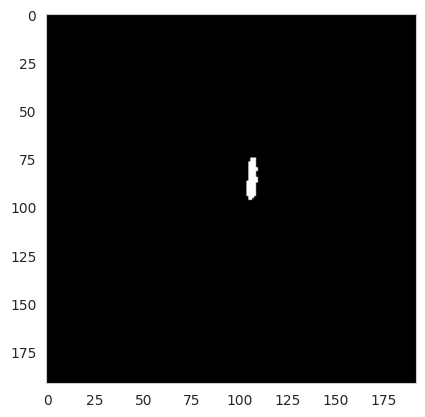

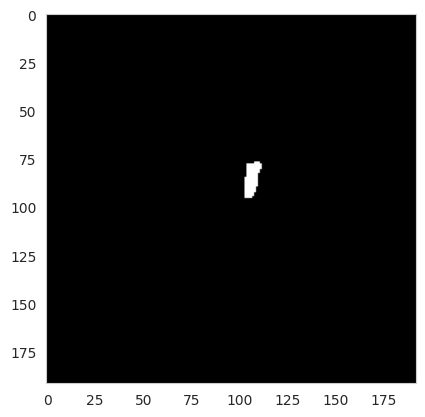

view: y


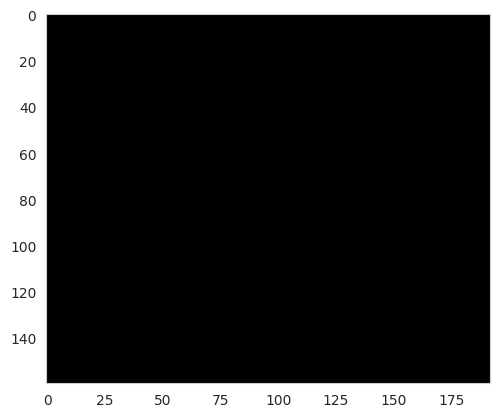

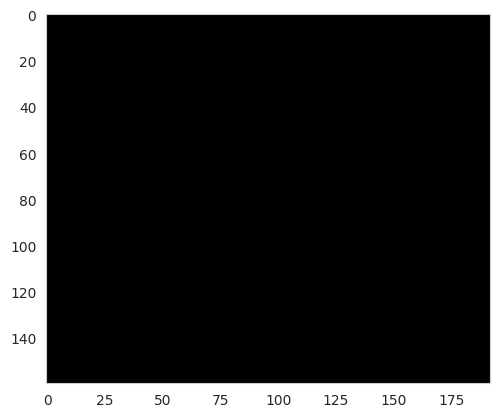

view: z


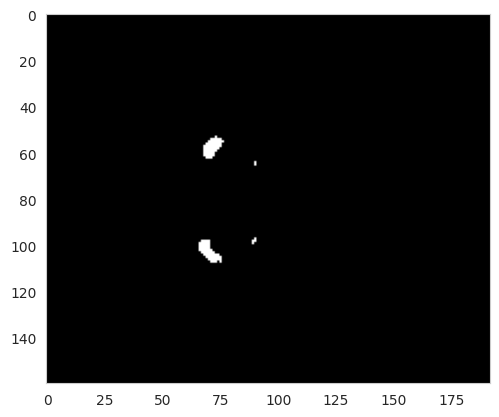

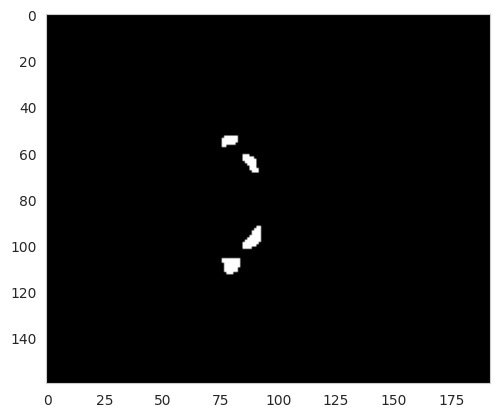

In [ ]:
for i in range(110, 111):
  print(i)
  print('Maper Segmentation registered to SNT Segmentation')
  print('view: x')
  plt.imshow(snt_ordered_binary_masks_all[5][i,:,:], cmap='gray')
  plt.show()
  plt.imshow(maper_reg_to_snt_binary_masks_all[5][i,:,:], cmap='gray')
  plt.show()

  print('view: y')
  plt.imshow(snt_ordered_binary_masks_all[5][:,i,:], cmap='gray')
  plt.show()
  plt.imshow(maper_reg_to_snt_binary_masks_all[5][:,i,:], cmap='gray')
  plt.show()

  print('view: z')
  plt.imshow(snt_ordered_binary_masks_all[5][:,:,i], cmap='gray')
  plt.show()
  plt.imshow(maper_reg_to_snt_binary_masks_all[5][:,:, i], cmap='gray')
  plt.show()

In [ ]:
# make dictionary of which list of scan is regsitered to which other list of scans -> to compute the dice/jaccard score:

dict_reg_masks_tools = {
    'MAPER to SNT' : (snt_ordered_binary_masks_all, maper_reg_to_snt_binary_masks_all),
    'FS to SNT' : (snt_ordered_binary_masks_all, fs_reg_to_snt_binary_masks_all),
    'MAPER to FS' : (FS_ordered_binary_masks_all, maper_reg_to_fs_binary_masks_all),
}

In [ ]:
#export dice scores as a csv file which can be loaded in 

dice_scores_list_Maper_reg_Snt, jaccard_scores_list_Maper_reg_Snt = compare_dice_two_tools_register_masks(snt_ordered_binary_masks_all, maper_reg_to_snt_binary_masks_all)
dice_scores_list_FS_reg_Snt, jaccard_scores_list_FS_reg_Snt = compare_dice_two_tools_register_masks(snt_ordered_binary_masks_all, fs_reg_to_snt_binary_masks_all)
dice_scores_list_Maper_reg_FS, jaccard_scores_list_Maper_reg_FS = compare_dice_two_tools_register_masks(FS_ordered_binary_masks_all, maper_reg_to_fs_binary_masks_all)

print(dice_scores_list_Maper_reg_Snt)


#df_dice_scores_list_Maper_reg_Snt.to_csv('dice_scores_list_Maper_reg_Snt1.csv') 
#df_jaccard_scores_list_Maper_reg_Snt.to_csv('jaccard_scores_list_Maper_reg_Snt1.csv') 

[0.6271973768102742, 0.5854134165366615, 0.592032967032967, 0.5630537022859018, 0.5688642659279778, 0.5926365795724465, 0.5566974394704756, 0.6185359301544661, 0.597488038277512, 0.5929946743138058, 0.555531914893617, 0.30323353293413174, 0.5483295684223042, 0.5783932467039742, 0.5825223631180576, 0.5017182130584192, 0.512217611802674, 0.5582112567463376, 0.504650024473813, 0.5401892922729199, 0.5398976982097187, 0.49778924097273397, 0.5268654984333294, 0.5903440821473608, 0.2587355761417195, 0.5385863267670915, 0.48156776757571607, 0.4495366892061107, 0.6097963676389653, 0.4656530002715178]


In [ ]:
dice_scores_list_list = []
jaccard_scores_list_list = []

for key in dict_reg_masks_tools.keys():
  masks_tool1 = dict_reg_masks_tools[key][0]
  masks_tool2 = dict_reg_masks_tools[key][1]

  dice_scores_list, jaccard_scores_list = compare_dice_two_tools_register_masks(masks_tool1, masks_tool2)
  dice_scores_list_list.append(dice_scores_list)
  jaccard_scores_list_list.append(jaccard_scores_list)


In [ ]:
df_jaccard_scores_list_list = pd.DataFrame(jaccard_scores_list_list)

In [ ]:
df_dice_scores_list_list = pd.DataFrame(dice_scores_list_list)
display(df_dice_scores_list_list)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.627197,0.585413,0.592033,0.563054,0.568864,0.592637,0.556697,0.618536,0.597488,0.592995,...,0.539898,0.497789,0.526865,0.590344,0.258736,0.538586,0.481568,0.449537,0.609796,0.465653
1,0.581429,0.411060,0.392762,0.564754,0.522963,0.394468,0.434818,0.437621,0.530261,0.534483,...,0.285289,0.420546,0.463029,0.523194,0.000000,0.371371,0.463069,0.474676,0.524226,0.446475
2,0.629017,0.473204,0.524608,0.569372,0.574027,0.438262,0.529910,0.509904,0.606387,0.604971,...,0.555340,0.471998,0.545134,0.629290,0.519323,0.495470,0.567849,0.463368,0.630715,0.415536


In [ ]:
# colorcoding the x_ticks which represent the different patient ids depending on the diagnosis of the patient -> there are three different diagnosis and 10 patients of each type (previously ordered)
colors = ['blue', 'red', 'purple']
tick_colors_list = []

for i in range(len(colors)):
  for j in range(10):
    tick_colors_list.append(colors[i])

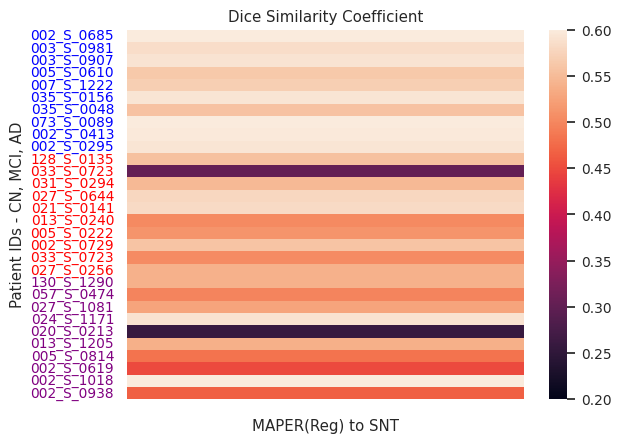

In [ ]:
# creating a heatmap for several patients and a combination of the cropped segmentations by different tools 
# dice_matrix_crop_ordered_all_arr = np.array(dice_matrix_crop_ordered_all)

sns.set(font_scale=0.9)
ax = sns.heatmap(np.reshape(dice_scores_list_Maper_reg_Snt,(len(jaccard_scores_list_Maper_reg_Snt),1)), yticklabels=diagnosis_ids.columns, xticklabels=[''], vmin=0.2, vmax=0.6)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)

for i, ticklabel in enumerate(ax.yaxis.get_majorticklabels()):
    ticklabel.set_color(tick_colors_list[i])

ax.set_title('Dice Similarity Coefficient')
ax.set_ylabel('Patient IDs - CN, MCI, AD')
ax.set_xlabel('MAPER(Reg) to SNT')

plt.show()

In [ ]:
axis_labels = ['MAPER to SNT', 'FS to SNT']

Text(47.24999999999999, 0.5, 'Segmentation Tools')

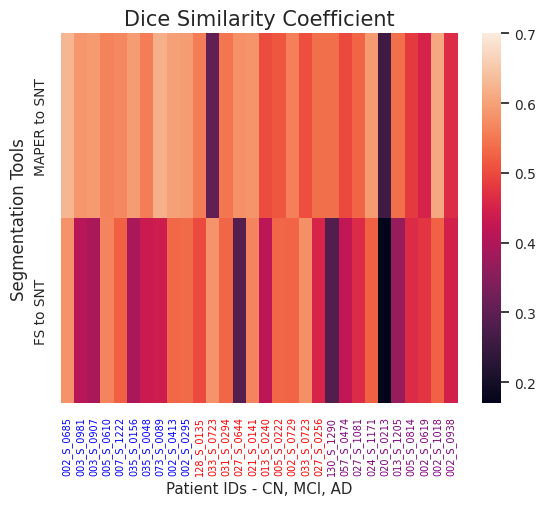

In [ ]:
ax = sns.heatmap(df_dice_scores_list_list[:2],  xticklabels=diagnosis_ids.columns, yticklabels=axis_labels, vmin=0.17, vmax=0.7)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)

for i, ticklabel in enumerate(ax.xaxis.get_majorticklabels()):
    ticklabel.set_color(tick_colors_list[i])

ax.set_title('Dice Similarity Coefficient', fontsize=15)
ax.set_xlabel('Patient IDs - CN, MCI, AD')
ax.set_ylabel('Segmentation Tools', fontsize=12)


Text(47.24999999999999, 0.5, 'Segmentation Tools')

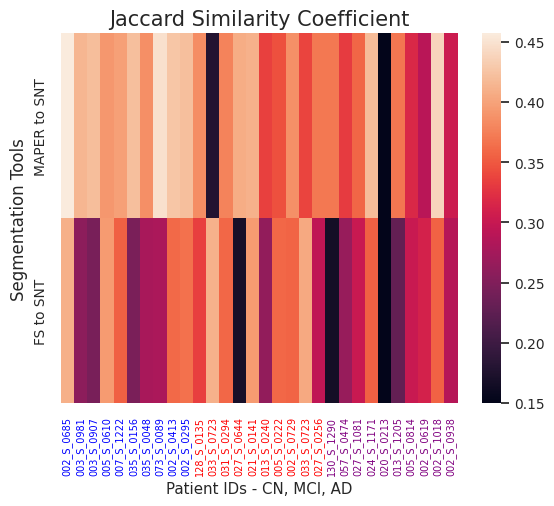

In [ ]:
ax = sns.heatmap(df_jaccard_scores_list_list[:2],  xticklabels=diagnosis_ids.columns, yticklabels=axis_labels, vmin=0.15)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)

for i, ticklabel in enumerate(ax.xaxis.get_majorticklabels()):
    ticklabel.set_color(tick_colors_list[i])

ax.set_title('Jaccard Similarity Coefficient', fontsize=15)
ax.set_xlabel('Patient IDs - CN, MCI, AD')
ax.set_ylabel('Segmentation Tools', fontsize=12)

In [ ]:
def read_scores_from_csv(filename):
  scores = pd.read_csv(filename, sep=',')
  scores = scores.T
  scores = list(scores.iloc[1])

  return scores

In [ ]:
print(read_scores_from_csv('dice_scores_list_Maper_reg_Snt.csv'))

[0.6128682450750045, 0.5778904269838175, 0.5925798694606664, 0.5618076121531206, 0.5759360071103211, 0.5922848664688427, 0.5772798879747943, 0.6159554730983302, 0.5864453665283541, 0.5971097673465204, 0.5895048666948793, 0.6227045075125208, 0.5661842569714084, 0.5692709304493754, 0.5839960726558665, 0.4836261980830671, 0.5065083352363553, 0.5812923397602918, 0.6169096209912537, 0.5447177193963108, 0.5458756916741732, 0.4880014654698663, 0.5221776504297995, 0.585473091804432, 0.0133877551020408, 0.5154022988505748, 0.5069860279441117, 0.4464847189032826, 0.5956982203297303, 0.4696399785061795]


In [ ]:
# make dictionary of which reads in the previously computed and saved dice/jaccard scores for each patient as it takes really long to re-run the registering and score computing each time the 
# notebook is run 

dict_dice_scores_tools = {
    'MAPER to SNT' : read_scores_from_csv('dice_scores_list_Maper_reg_Snt.csv'),
    'FS to SNT' : read_scores_from_csv('dice_scores_list_FS_reg_Snt.csv'),
    'MAPER to FS' : read_scores_from_csv('dice_scores_list_MAPER_reg_FS.csv'),
    'SNT to FS' : read_scores_from_csv('dice_scores_list_SNT_reg_FS.csv'),
    'SNT to MAPER' : read_scores_from_csv('dice_scores_list_SNT_reg_MAPER.csv'),
    'FS to MAPER' : read_scores_from_csv('dice_scores_list_FS_reg_MAPER.csv'),
}

In [ ]:
df_dice_scores_stored = pd.DataFrame(dict_dice_scores_tools)
display(df_dice_scores_stored)

,MAPER to SNT,FS to SNT,MAPER to FS,SNT to FS,SNT to MAPER,FS to MAPER
0,0.612868,0.603307,0.700944,0.684081,0.660859,0.644141
1,0.577890,0.463240,0.565323,0.558721,0.595157,0.440630
2,0.592580,0.419504,0.553445,0.498811,0.634001,0.451672
3,0.561808,0.620498,0.633423,0.686125,0.628788,0.622648
4,0.575936,0.542792,0.703588,0.719247,0.612178,0.607705
5,0.592285,0.418128,0.498937,0.446994,0.621368,0.438714
6,0.577280,0.497554,0.539775,0.591310,0.583461,0.423366
7,0.615955,0.430134,0.541462,0.520417,0.616082,0.372210
8,0.586445,0.589966,0.692064,0.646801,0.657718,0.629208
9,0.597110,0.520264,0.686178,0.644988,0.657046,0.597159


In [ ]:
yaxis_labels = list(df_dice_scores_stored.columns)

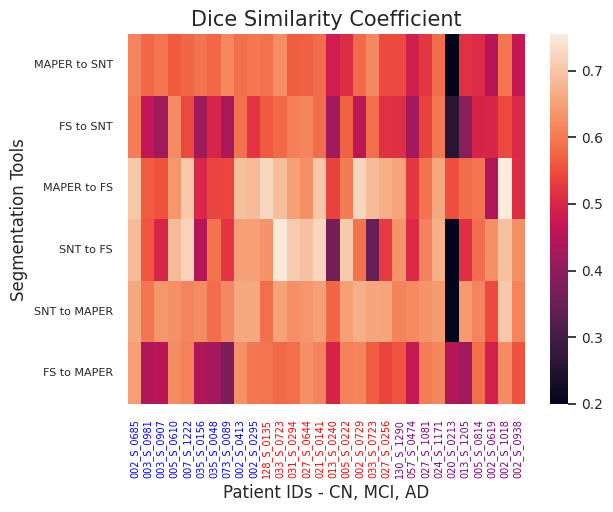

In [ ]:
ax = sns.heatmap(df_dice_scores_stored.T, xticklabels=diagnosis_ids.columns, yticklabels=yaxis_labels, vmin=0.2 )
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)

for i, ticklabel in enumerate(ax.xaxis.get_majorticklabels()):
    ticklabel.set_color(tick_colors_list[i])

ax.set_title('Dice Similarity Coefficient', fontsize=15)
ax.tick_params(axis='both', which='major', pad=5)
ax.set_xlabel('Patient IDs - CN, MCI, AD', fontsize=12)
ax.set_ylabel('Segmentation Tools', fontsize=12)

plt.show()

End.